In [113]:
import os
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from intensity_normalization.normalize import fcm
%matplotlib inline

## Get path to images 

In [115]:
root ="BrainPTM"
annotations = [label for label in Path(root, "Annotations").glob("**/*.gz")]
data = [im for im in Path(root, "data").glob("**/*.gz")]
dataT1=[]
dataDiff =[]
dataMask= []

#Separate images into T1, Difussion and brain mask
for i in range(0,len(data)):
    if "T1" in str(data[i]):
        dataT1.append(str(data[i]))
    elif "Diffusion" in str(data[i]):
        dataDiff.append(str(data[i]))
    else:
        dataMask.append(str(data[i]))
        
dataT1.sort()
dataMask.sort()


or_left =[]
or_right=[]
cst_left=[]
cst_right=[]
        
#Stores masks of each tract in a separate list
for i in range(0,len(annotations)):
    if "OR_left" in str(annotations[i]):
        or_left.append(annotations[i])
    elif "OR_right" in str(annotations[i]):
        or_right.append(annotations[i])
        
    elif "CST_right" in str(annotations[i]):
        cst_right.append(annotations[i])
        
    elif "CST_left" in str(annotations[i]):
        cst_left.append(annotations[i])

#Tract used to perform training and testing
tract_mask=or_right


## Normalizing the T1 volumes
Performs fcm normalization on T1 volumes and stores the normalized volumes in a directory.

*intensity-normalization module needed, dowloaded from: https://github.com/jcreinhold/intensity-normalization*


In [90]:
image = nib.load(dataT1[0])
mask=nib.load(dataMask[0])
normalized = fcm.fcm_normalize(image, mask)
nrmdir = os.path.join("WMTdata", "T1") # Directory to store Normalized T1 volumes

if os.path.isdir(nrmdir):
    print("The directory already exists")
else:
    os.mkdir(nrmdir)
    
    print("-" *89)
    print("Normalization of T1 volumes")
    print("-" *89)
    
    for i in range(len(dataT1)):
        assert Path(dataT1[i]).parent.name == Path(dataMask[i]).parent.name
        
        image = nib.load(dataT1[i])
        mask=nib.load(dataMask[i])
        normalized = fcm.fcm_normalize(image, mask)
        name = Path(dataT1[i]).parent.name + ".nii.gz"
        nib.save(normalized, os.path.join(nrmdir,name))
        
        if i%6 ==0:
            percent =100*i/len(dataT1)
            txt = "{percent}% normalized"
            print(txt.format(percent =np.floor(100*i/len(dataT1))))
        if i == len(dataT1) -1:
            print("100.0% normalized")

The directory already exists


### The original images have values between 0 and 3000 (or even 0 and 30000), we perform normalization to narrow that range

#### Range of not normalized images:

In [108]:
mi=10000000
ma=-1000000000000
for im in dataT1:
    img = nib.load(im).get_fdata()
    if np.min(img) < mi:
        mi =np.min(img)
    if np.max(img) > ma:
        ma = np.max(img)
 

txt = "Values in range: [{min}, {max}] (max range)"
print(txt.format(min =mi, max=ma ))

Values in range: [0.0, 32767.0] (max range)


#### Range of normalized images:

In [111]:
mi=10000000
ma=-1000000000000
normalizedT1 = [im for im in Path(nrmdir).glob("*.gz")]
for im in normalizedT1:
    img = nib.load(im).get_fdata()
    if np.min(img) < mi:
        mi =np.min(img)
    if np.max(img) > ma:
        ma = np.max(img)
 

txt = "Values in range: [{min}, {max}] (max range)"
print(txt.format(min =mi, max=ma ))

Values in range: [0.0, 4.00873647617118] (max range)


### Visualize images 

(-0.5, 127.5, 143.5, -0.5)

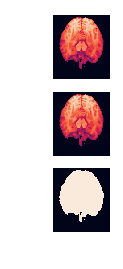

In [112]:
im = image.get_fdata().T[50,:,:]
ann = mask.get_fdata().T[50,:,:]
nrm = normalized.get_fdata().T[50,:,:]

fig, (ax1,ax2,ax3) = plt.subplots(3,1)
ax1.imshow(im)
ax1.axis('off')
ax2.imshow(nrm)
ax2.axis('off')
ax3.imshow(ann)
ax3.axis('off')

After the normalization the images were converted to 2d in tiff format with nii_to_tif method from https://gist.github.com/jcreinhold/01daf54a6002de7bd8d58bad78b4022b *(It is important to evaluate the algorithm without the normalization before 2d transformation i.e perform segmentation without all this preprocessing)*

python nii_to_tif.py *(nifti input folder)* /home/fjmoya/FinalProject/wm-segmentation/WMTdata/T1 *(tif output folder)* /home/fjmoya/FinalProject/wm-segmentation/WMTdata/T1_tif

In [125]:
#Copy tract_mask to a separate directory
import shutil
for im in tract_mask:
    name =im.name
    case=im.parent.name
    dirp ="/home/fjmoya/FinalProject/wm-segmentation/WMTdata/Annotations"
    out = Path(dirp,case+name)
    shutil.copyfile(im, out)


python nii_to_tif.py /home/fjmoya/FinalProject/wm-segmentation/WMTdata/Annotations /home/fjmoya/FinalProject/wm-segmentation/WMTdata/AnnotationsTif
